## "Classical ML"

Here by classical ML we loosely refer to ML that does not employ neural networks. They are classical mainly since these are the methods that used to perform well (and still do) before the neural networks started to shine in the most difficult M tasks, like image recognition, language processing etc.  

One should always when performing ML think whether the methods applied are well suited to the problem at hand. Quite often it may turn out that the 'simpler' classical methods can perform equally well, be more interpretable, and easier to use than neural networks. This is in no way to say that one should favor one method over another - it is just trying to point out that sometimes you do not need to hit a fly with an axe. 

#### What you should learn:
1. How to consider/evaluate the 'difficulty' of given task to evaluate the proper **level of giving up** (logu).
2. What is a Tree Classifier
3. How do you use Tree Classifier in sklearn and what to keep in mind when using it.
3. *Optional* - What is information entropy and how is Tree Classifier build using it. 
4. Understand what is and how to visualize the decision path from a tree classifer.
5. What is a random forest classifier (RF).
6. Why it interpretation of RF is difficult.
7. Plot the decision surfaces in simple cases for visualization.
8. Evaluate classifier performance using confusion matrix and extract metrics for performance evaluation from the confusion matrix. 



In [120]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns 
from sklearn.model_selection import train_test_split

%matplotlib inline 
# Define some plotting params:
mpl.rcParams['figure.figsize'] = (12,6)
sns.set_style("whitegrid", {"axes.facecolor": ".97"})

# Load the penguins dataset:
data = sns.load_dataset('penguins').dropna()

# Define the target:
target = 'species'

X = data.drop(columns=target)
y = data.loc[:, target]
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Tree Classifier

Tree classifiers are one of the simplest ML methods out there. Tree training is based on a process where at each node you find a feature and a split value (f, $x_f$) such that if the instances in that current node are splitted accordingly the resulting two nodes are as pure as possible. This is continued until no split can be performed (pure nodes) or a termination condition is reached. We shall make this clear by example.



In [123]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_validate

tree = DecisionTreeClassifier(max_depth=2, criterion='entropy')

cross_validate(tree, X, y) # Will prdoce error!

{'fit_time': array([0.0069418 , 0.00483894, 0.00603032, 0.00525641, 0.00437903]),
 'score_time': array([0.00376797, 0.00367665, 0.00386643, 0.00367832, 0.00200915]),
 'test_score': array([0.97014925, 0.94029851, 0.94029851, 0.92424242, 0.95454545])}

What is this! The stuff crashed. Lets look at the data training data $\mathbf{X}$. Notice the features **island** and **sex**. They are objects and thus tree classifier crashes whren trying to find splits by comparing: female > male... Here we shall just drop these feeatures, bu they could also be encoded using sklearn.encoding.OneHotEncoder to numerical values.

In [122]:
display(X.head())
X = X.drop(columns=['sex', 'island'])
X_train = X_train.drop(columns=['sex', 'island'])
X_test = X_test.drop(columns=['sex', 'island'])
print('After dropping the categorical features:')
X.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Torgersen,39.3,20.6,190.0,3650.0,Male


After dropping the categorical features:


,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0


Lets then see the cross valitaded accuracy score:

In [124]:
metric = 'accuracy'
score = cross_validate(tree, X, y, scoring=metric)['test_score'].mean()
print('Mean {} = {:.3f}'.format(metric, score))

Mean accuracy = 0.946


We get reasonable classification score even without the removed features so this is fine. Lets us look how a DecisionTreeLooks:

### Use dtreeviz to display the classification tree: 
You need to undestand what a histogram/distribution is to get the point of the below cell.

In [125]:
from sklearn.preprocessing import LabelEncoder
from dtreeviz.trees import *

tree_clf = DecisionTreeClassifier(max_depth=3)  # limit depth of tree

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
tree_clf.fit(X_train, y_train_enc)


viz = dtreeviz(tree_clf,
               X_train,
               y_train_enc,
               target_name='variety',
               feature_names=X_train.columns, 
               class_names=list(le.classes_),
               scale=2,
               X=X_test.iloc[0]) 
              
viz.view()

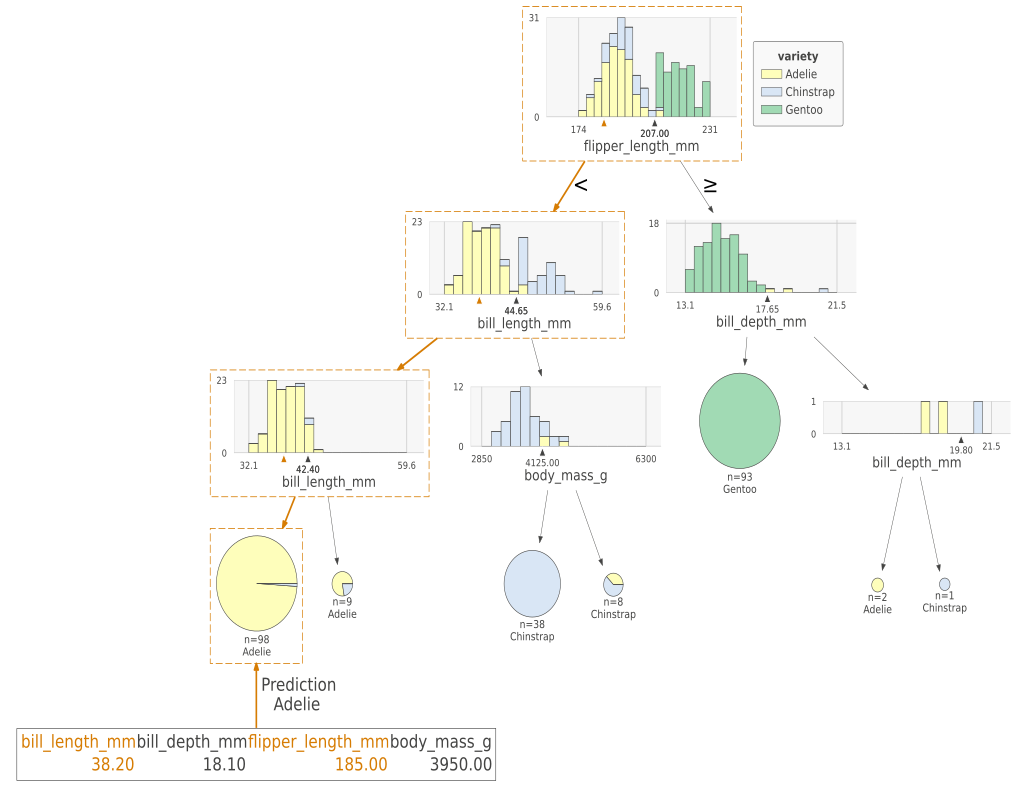

In [106]:
#In case above cell crashes due to missing graphviz or so
from IPython.display import Image

Image("DecisionPath.png")

## Math behind tree node splitting (optional):

First we though need to define what *pure* means. We can measure the purity of a node by the amount of information entropy:

$
H(y) = -\sum_{i \in \text{classes}}  p(i) \log_2 p(i),
$

where $p(i)=\frac{n_i}{n}$ is the probability to find instances of class $i$ in node under consideration. One can see that in the sum if $p(i) \in \{0, 1\}$ the contribution is 0. That is, pure nodes have $H=0$. We want to use $H$ to reason by which feature to split and where to place the split boundaries (see above fig.).

After a given split (*feature*, $t$) we obtain two nodes - one on the left for instances with $\mathcal{L} = \{(\mathbf{x}, y) | x_\text{feature} < t, ~ \mathbf{x} \in \mathbf{X}_\text{train}\}$ and the other on the right for intances $\mathcal{R} = \{(\mathbf{x}, y) | t \leq x_\text{feature}, ~\mathbf{x} \in \mathbf{X}_\text{train} \}$. We consider *information gain* in this split process: 

$
\text{IG}(y, a) = H(y) - H(y|a),  
$ 

where $a \in \{\mathcal{L}, \mathcal{R}\}$ and $H(y|a)$ is the *conditional entropy*, that is, the information entropy that still remains when knowledge of the split side ($\mathcal{L}, \mathcal{R}$) is exposed. This can be viewed as asking "if I have a = $\mathcal{L}$ what I can say about y?".

$
H(y|a) = -\sum_{i \in \text{classes}} p(i|a) \log_2 p(i|a)
$

If the node is pure then conditional entropy goes to zero since the target class is completely determined by the split side. We perform split such that the expectation value of information gain is maximized, i.e.,

$
\text{I}(y; A) = \text{E}_A[\text{IG}(y, a)] = H(y) - \sum_{a\in\{\mathcal{L}, \mathcal{R}\}} p(a) H(y|a).
$

Equipped with above Eq. one only needs to find a split that maximizes the *mutual information* I$(y;A)$.  

## Random Forest Classifier:  
Radnom forest is a collection of tree classifiers where each tree is constrained to produce a sub-optimal tree. However, when combine the forest performs better tha a single 'optimal tree'.  
Creating a RF and fitting a RF classifier is this easy:

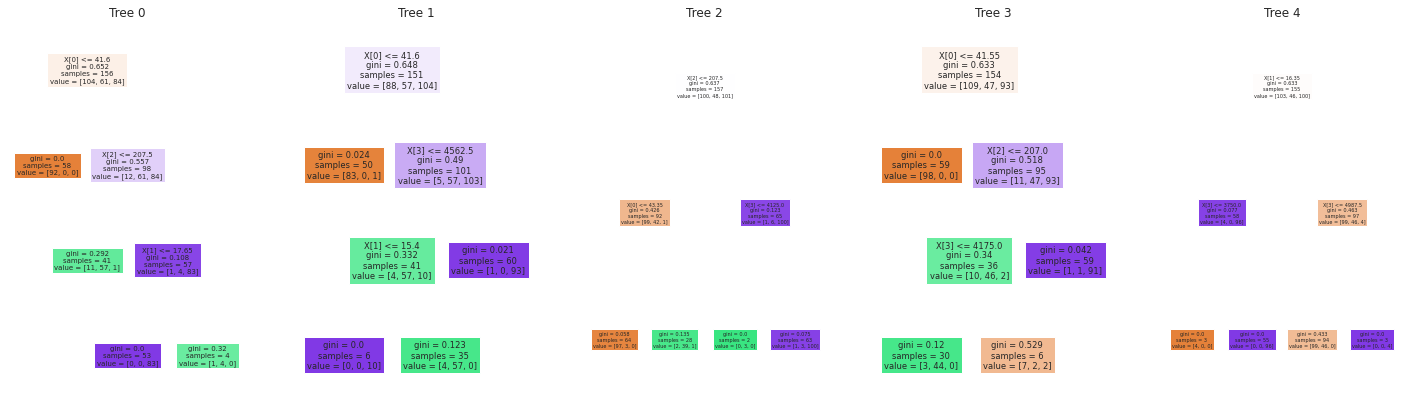

In [130]:
from sklearn.ensemble import RandomForestClassifier

# Create and fit the RF classifier:
rf = RandomForestClassifier(n_estimators=5, max_leaf_nodes=4).fit(X_train, y_train)

from sklearn.tree import plot_tree

# The rf was fitted to whatever in prev cell..
rf.fit(X_train, y_train)
_, axarr = plt.subplots(1, rf.n_estimators, figsize=(25, 7))



for i, tree_clf, ax in zip(range(rf.n_estimators), rf.estimators_, axarr):
    plot_tree(tree_clf, filled=True, ax=ax)
    ax.set_title('Tree {}'.format(i))
    viz = dtreeviz(tree_clf,
                   X_train,
                   y_train_enc,
                   target_name='variety',
                   feature_names=X_train.columns, 
                   class_names=list(le.classes_),
                   scale=2,
                   X=X_test.iloc[0]) 
              
    #plt.show()

### To display the differences in Tree and RF classifiers complexity we shall now plot their decision surfaces in simple 2d case.

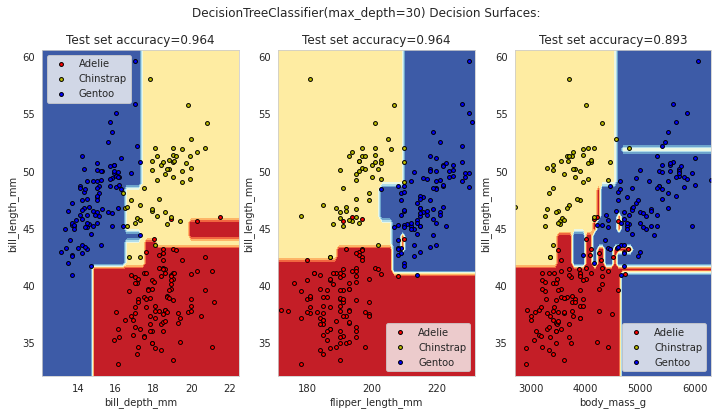

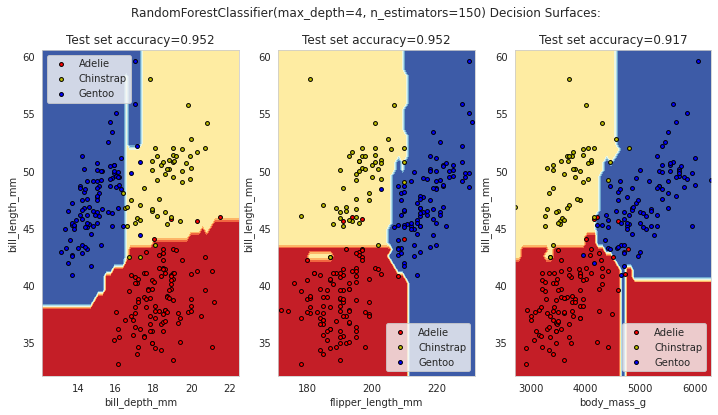

In [132]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

def plot_decision_surfaces(clf, X_train, y_train, X_test, y_test, ax=None):
    """
    Plot the decision surfaces of given classifier when only
    2-features are present.
    Args:
        clf: classifier for which the surfaces are plotted:
        X_train: training data shape (N, 2).
        y_train: training data labels.
        X_test: test data shape (M, 2).
        y_test: test data labels.
        ax: axes to which plot, if None - create figure
    Return:
        ax: the axes with decision surfaces plotted.
    """
    
    
    if ax is None:
        _, ax = plt.subplots()
    
    if isinstance(X_train, pd.DataFrame):
        xlabel, ylabel = X_train.columns
        X_train = X_train.values
        X_test = X_test.values
    
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    
    clf.fit(X_train, y_train)
    
    # Create a meshgrids of x and y values
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    
    Z = clf.predict(np.vstack((xx.ravel(), yy.ravel())).T)
    Z = Z.reshape(xx.shape)
    
    cs = ax.contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
    
    # Plot the training points
    for i, color in enumerate('ryb'):
        mask = y_train == i
        ax.scatter(X_train[mask, 0], X_train[mask, 1], 
                    c=color, label=le.inverse_transform([i])[0],
                    cmap=plt.cm.RdYlBu, edgecolor='black', s=15)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    # Extract the clf score in the test set: (remember to transform the test set labels since the classifier was trained with tranformed rtain set ealier.
    metric_value = accuracy_score(le.transform(y_test), clf.predict(X_test))
    ax.set_title('Test set {}={:.3f}'.format('accuracy', metric_value))
    ax.legend()
    
    return ax

def decision_surfaces_row(clf):
    fig, axrow = plt.subplots(1,len(feature_pair_list))
    for features, ax in zip(feature_pair_list, axrow):
        plot_decision_surfaces(clf, X_train.loc[:, features], y_train, X_test.loc[:, features], y_test, ax=ax)
    fig.suptitle('{} Decision Surfaces:'.format(clf))
    

feature_pair_list = [['bill_depth_mm', 'bill_length_mm'],
                     ['flipper_length_mm', 'bill_length_mm'],
                     ['body_mass_g', 'bill_length_mm']]

# PLot for TREE:
tree_clf = DecisionTreeClassifier(max_depth=30) 
decision_surfaces_row(tree_clf)

# PLot for RF:
rf = RandomForestClassifier(n_estimators=150, max_depth=4) 
decision_surfaces_row(rf)

### Underfitting/Overfitting

It is clear from the figures above, that the Tree classifier is doing something suboptimal. It is overfitting - let us now see how the classifier parameters can lead to under/overfitting.

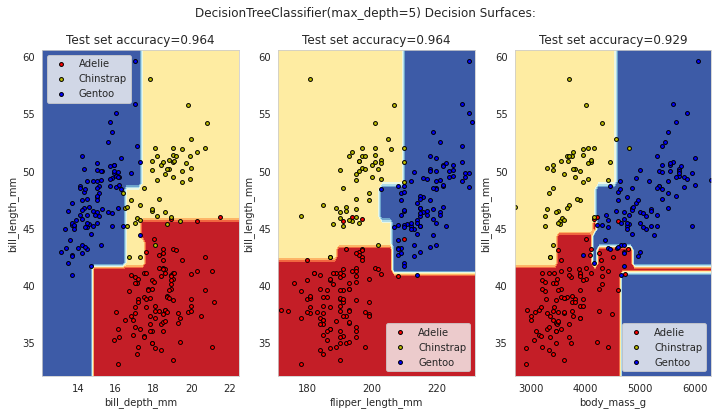

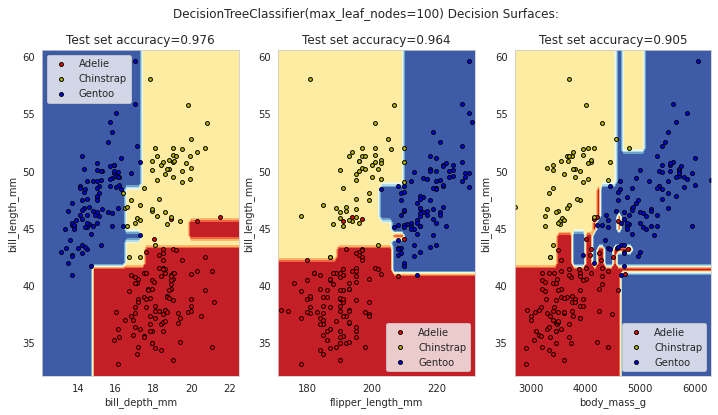

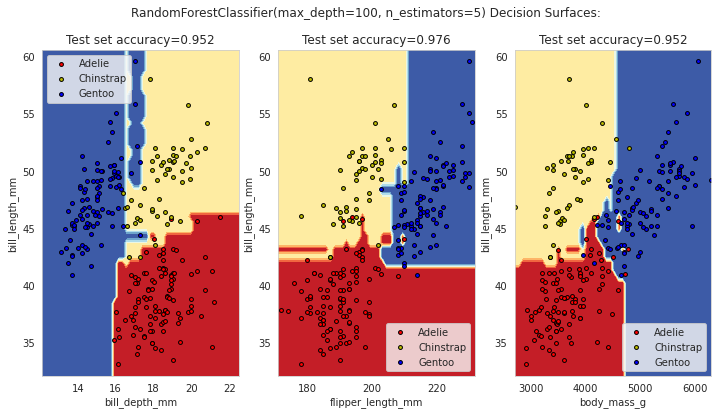

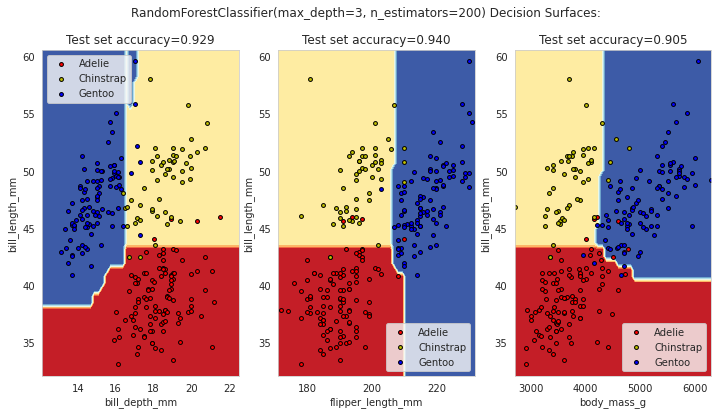

In [138]:
decision_surfaces_row(DecisionTreeClassifier(max_depth=5))
decision_surfaces_row(DecisionTreeClassifier(max_leaf_nodes=100))
decision_surfaces_row(RandomForestClassifier(n_estimators=5, max_depth=100))
decision_surfaces_row(RandomForestClassifier(n_estimators=200, max_depth=3))

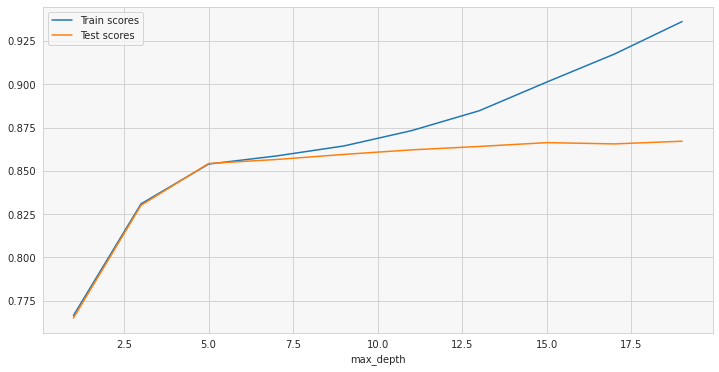

In [97]:
from sklearn.datasets import fetch_openml

def plot_train_valid(clf, clf_args, score=accuracy_score):
    
    scores = np.zeros((len(clf_args), 3))
    
    for i, clf_arg in enumerate(clf_args):
        clf.set_params(**dict([clf_arg]))
        clf.fit(X_train, y_train)
        scores[i, 0] = clf_arg[1]
        scores[i, 1] = score(y_train, clf.predict(X_train))
        scores[i, 2] = score(y_test, clf.predict(X_test))
        
    
    plt.plot(scores[:, 0], scores[:, 1], label='Train scores')
    plt.plot(scores[:, 0], scores[:, 2], label='Test scores')
    plt.xlabel(clf_arg[0])
    plt.legend()
    plt.show()
    
adult = fetch_openml(name='adult', version=2)
X = pd.DataFrame(data=adult.data, columns=adult.feature_names).fillna(method='pad') 
y = adult.target

X_train, X_test, y_train, y_test = train_test_split(X, y)
    
rf = RandomForestClassifier(n_estimators=100)

clf_args = [('max_depth', max_d) for max_d in np.arange(1, 20, 2)]
plot_train_valid(rf, clf_args)

### Questions:
1. Why is the Decision surfaces of rf so much more complicated as compared to tree classifier?
2. What is the main restriction currently imposed on the tree calssifier?
3. What can become an issue if the RF is let to fit even more precisely to the training data.
4. Why does the tree obtain such a low score even while the figures above shoved that the training examples seemed to be perfectly separated?